# <p style="text-align: center;"> Home work on Attentional LSTM network </p>
### <p style="text-align: center;"> Paul Peyssard </p>
### <p style="text-align: center;"> Worked in collaboration with Aglind Reka, Trang Nguyen, Matheus Paula </p>
#### <p style="text-align: center;"> MSc Data Science & Artificial Intelligence </p>
#### <p style="text-align: center;"> Intro to deep learning </p> 
#### <p style="text-align: center;"> 11/02/2023 </p>

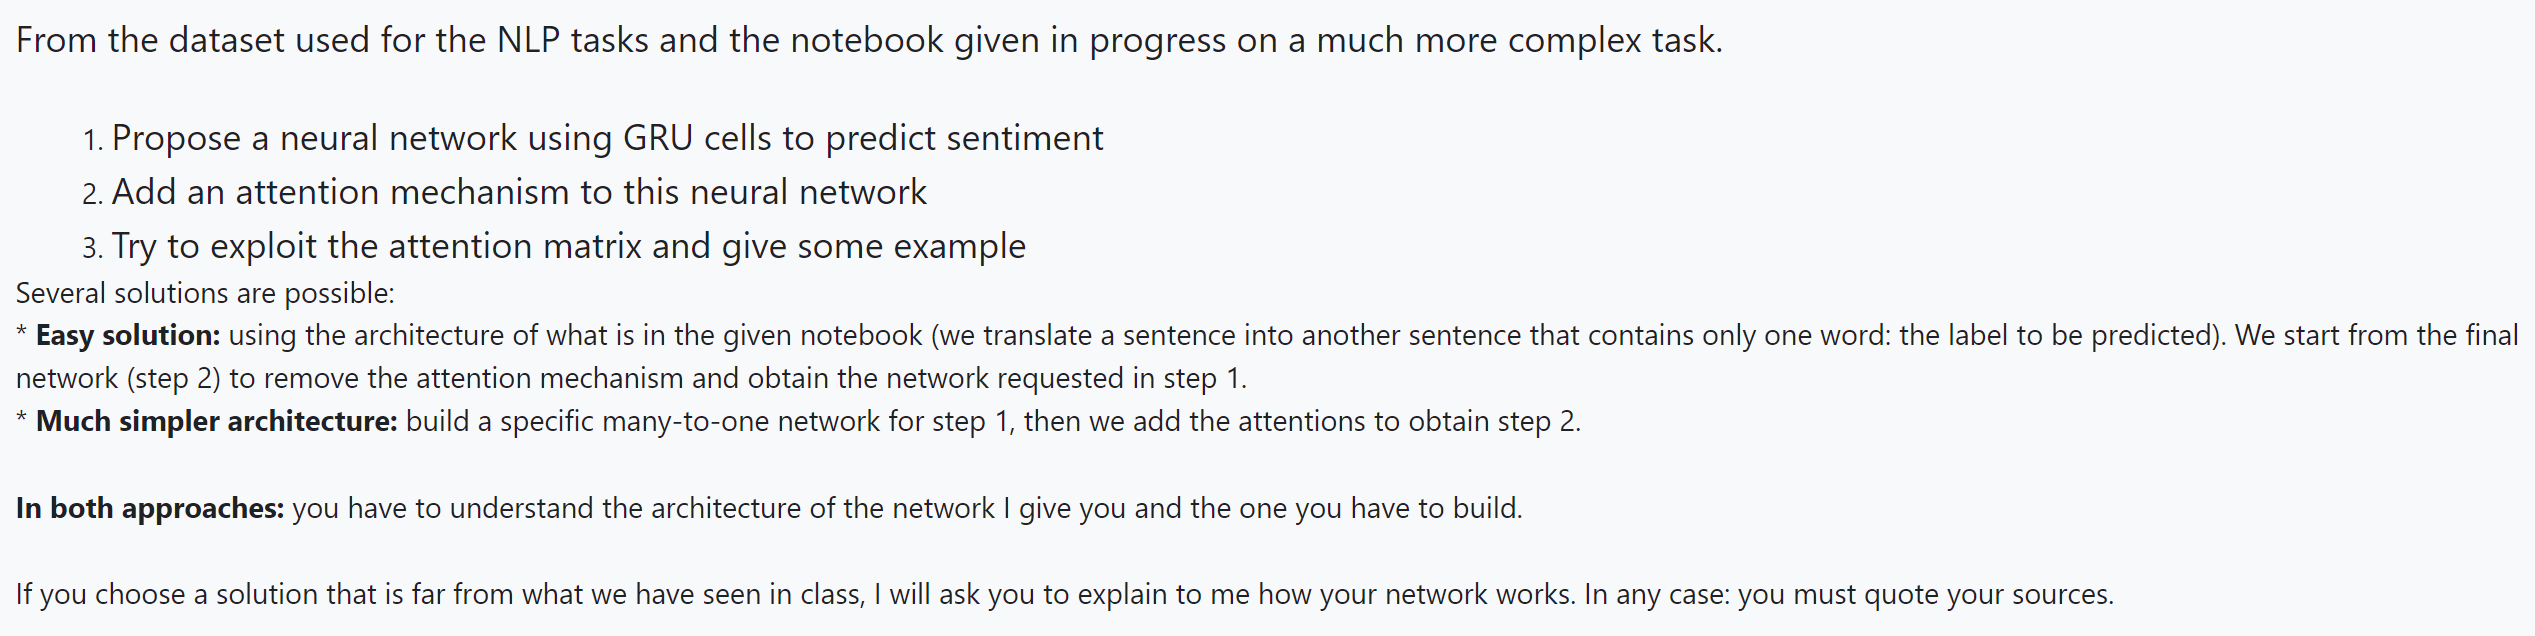

# Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer


In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import PorterStemmer

# Dataset

In [5]:
train = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
val = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
test = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

In [6]:
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)
print("Val shape : ",val.shape)

Train shape :  (5000, 6)
Test shape :  (1000, 6)
Val shape :  (1000, 6)


In [7]:
np.unique(train['Rating'])

array([1, 2, 3, 4, 5], dtype=int64)

### a) Checking the data
I also checked the test and val but I did not want to overload the notebook

In [8]:
train.head(1)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0


In [9]:
train.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
dtype: object

### b) Build X (features vectors) and y (labels)

Keeping only reviews as features to work on sentiment analysis

For the label, as we want to predict sentiment, we use the rating

In [10]:
# Construct X_train and y_train
X_train = train['Reviews'].fillna("")
X_train = np.array(train['Reviews'].fillna("")).reshape(-1,1)
y_train = train['Rating']
y_train = np.array(train['Rating']).reshape(-1,1)
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [11]:
# Construct X_test and y_test
X_test = test['Reviews'].fillna("")
X_test = np.array(test['Reviews']).reshape(-1,1)
y_test = test['Rating']
y_test = np.array(test['Rating']).reshape(-1,1)
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

In [12]:
# Construct X_val and y_val
X_val = val['Reviews'].fillna("")
X_val = np.array(val['Reviews']).reshape(-1,1)
y_val = val['Rating']
y_val = np.array(val['Rating']).reshape(-1,1)
X_val.shape, y_val.shape

((1000, 1), (1000, 1))

### c) Encode Ys

In [13]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_val_encoded = ohe.transform(y_val)
y_test_encoded = ohe.transform(y_test)

C:\Users\paul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### e) Text preprocessing

set the stopwords of english language

In [14]:
# nltk.download('stopwords')
stops = set(stopwords.words('english'))

del_stops(text) is used to delete stop words

In [15]:
def del_stops(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stops:
            filtered_sentence.append(w)
    result=' '.join(filtered_sentence)
    return result

I tuned the step1 function from lab notebook_NLP_seq2seq-Spanish2English-with-Luong-attention in order to remove more emojis, non latin character...

In [16]:
# Process the data
import unicodedata

def step1(sent):
    # sent = on sentence in a language
    def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    sent = unicode_to_ascii(sent.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)
    
    #removing emojis and non latin symbols (chinese, russian etc...)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    sent= re.sub(emoj, '', sent)
    

    return '<start> ' + sent.strip() + ' <end>' # and start and stop tag

clean_text(text) combine the previously implemented functions to lower the text, delete the stopwords, remove emojis and lemmatize the text

In [17]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
import re
#Those are the cleaning functions we already used in previous machine learning labs

def clean_text(text):
    text=text.lower() #lowercase the text
    #text=re.sub(r'[^\w\s]', '', text) #remove punctuation  Voir si besoin de ça
    text=del_stops(text) #delete stop words
    text=lemmatizer.lemmatize(text)
    text=step1(text)
    return text

Applying clean_text() on train,test,val

The val set had one float element so I added astype(str) so it could run

In [18]:
X_train_p = np.array([clean_text(r) for r in X_train.flatten()])
X_test_p = np.array([clean_text(r) for r in X_test.flatten()])
X_val_p = np.array([clean_text(r) for r in X_val.flatten().astype(str)]) 

In [19]:
X_train_p[0]

'<start> love ! ! ! absolutely love ! ! <end>'

### Defining the babysit function in order to observe the learning curves of the models
babysit() is the same function we used several times in previous labs

In [20]:
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

# Model

Some constant to build the model

In [21]:
BATCH_SIZE = 32
embedding_dim = 50
latent_dim = 64
dropout=0.3

Let's take only a small amount of data because it is a very large dataset


In [22]:
elements=500
X_train_p=X_train_p[0:elements]
y_train_encoded=y_train_encoded[0:elements]

Search vocabulary and max_length for the corpus

In [23]:
def voc(lang):
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])  
    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_reviews, vocab_reviews, vocab_size_reviews = voc(X_train_p)
rate_size=5
print(max_length_reviews, vocab_size_reviews,rate_size)


381 2513 5


Building of the TextVectorization

standardize=None as we already cleaned the data

output_mode= A DETERMINER PAS SUR SOIT INT SOIT MULTI-HOT

In [24]:
reviews_vectorizer = layers.TextVectorization(standardize=None, output_mode='multi_hot',
                                              name="reviews")

reviews_vectorizer.adapt(X_train_p)
# # On peut connaitre le vocabulaire par _vectorizer.get_vocabulary()
# reviews_vectorizer(X_train_p)


In [25]:
y_train_encoded[3]


array([0., 0., 0., 1., 0.])

#### Encoder parts

Starting from the reviews_vectorizer we created, we will start creating the encoder

In [26]:
encoder_inputs = layers.Input(shape=(1,), dtype=tf.string, name="encoder_start")

encoder_vectorizer = reviews_vectorizer(encoder_inputs)

encoder_embedding = layers.Embedding(vocab_size_reviews, embedding_dim, #embedd each token
                                     name="reviews_embedding")(encoder_vectorizer)

encoder_outputs, encoder_state = layers.GRU(
    latent_dim, 
    return_sequences=True,
    return_state=True,      
    dropout=dropout, 
    recurrent_dropout=dropout, 
    name="encoder")(encoder_embedding)

encoder_states = [encoder_state]

print(encoder_outputs.shape)

(None, 2512, 64)


#### Decoder Parts
We will use the final state of GRU encoder to initilaize the decoder

In [27]:
decoder_inputs = layers.Input(shape=(None,), dtype=tf.int32, name="english_teacher")

decoder_embedding = layers.Embedding(vocab_size_reviews+2,
                                     embedding_dim,
                                     name="english_embedding")(decoder_inputs)

decoder_outputs, decoder_state= layers.GRU(latent_dim, return_sequences=True, return_state=True,
                                                                dropout=dropout, recurrent_dropout=dropout, name="Decoder")(decoder_embedding, initial_state=encoder_states)

print(decoder_outputs.shape)

(None, None, 64)


In [28]:
decoder_inputs = layers.Input(shape=(1,), dtype=tf.float32, name="rate_teacher")

decoder_embedding = layers.Embedding(rate_size+2,
                                     embedding_dim,
                                     name="rate_embedding")(decoder_inputs)

decoder_outputs, decoder_state= layers.GRU(latent_dim, return_sequences=True, return_state=True,
                                                                dropout=dropout, recurrent_dropout=dropout, name="Decoder")(decoder_embedding, initial_state=encoder_states)

decoder_dense = layers.Dense(rate_size, activation='sigmoid', name="output_layer")


#### Attention

In [29]:
attention_encoder = layers.Dense(latent_dim, activation="tanh", name="dense_encoder")(encoder_outputs)
attention_decoder = layers.Dense(latent_dim, activation="tanh", name="dense_decoder")(decoder_outputs)
attention = layers.dot([attention_decoder, attention_encoder], axes=[2,2], name="Attention_score")
attention = layers.Activation('softmax', name="Attention_weight")(attention)
context = layers.dot([attention, encoder_outputs], axes=[2,1], name="Attention_output")
decoder_combined_context = layers.concatenate([context, decoder_outputs], name="Luong_Attention")
ouputs = layers.Dense(vocab_size_reviews, activation='sigmoid', name="Output")(decoder_combined_context)


In [30]:
model = Model([encoder_inputs, decoder_inputs], ouputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_start (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 reviews (TextVectorization)    (None, 2512)         0           ['encoder_start[0][0]']          
                                                                                                  
 rate_teacher (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 reviews_embedding (Embedding)  (None, 2512, 50)     125650      ['reviews[0][0]']                
                                                                                              

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [32]:
from tensorflow.keras.utils import to_categorical

rev_teacher_enc = to_categorical(y_train-1, num_classes = 5)
print(rev_teacher_enc)
#reviews_teacher_enc = reviews_vectorizer(X_train_p).numpy() # Teacher
rev_target_enc = np.zeros_like(rev_teacher_enc)
rev_target_enc[:,:-1] = rev_teacher_enc[:,1:] # To predict
rev_target_enc.shape

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


(5000, 5)

In [33]:
rev_teacher_enc[:,1:]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [34]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='min', min_delta=0.0000001,
                                patience=5, restore_best_weights=True, verbose=1,
                                )]

history = model.fit([X_train_p, rev_teacher_enc], rev_target_enc,
                    validation_split=0.3,
                    epochs=4000, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/4000
11/11 [==============================] - 45s 3s/step - loss: 7.6434 - accuracy: 0.7577 - val_loss: 7.1448 - val_accuracy: 0.8373
Epoch 2/4000
11/11 [==============================] - 34s 3s/step - loss: 4.4207 - accuracy: 0.8326 - val_loss: 1.4148 - val_accuracy: 0.8373
Epoch 3/4000
11/11 [==============================] - 35s 3s/step - loss: 0.9790 - accuracy: 0.8326 - val_loss: 0.6268 - val_accuracy: 0.8373
Epoch 4/4000
11/11 [==============================] - 35s 3s/step - loss: 0.5935 - accuracy: 0.8326 - val_loss: 0.5190 - val_accuracy: 0.8373
Epoch 5/4000
11/11 [==============================] - 36s 3s/step - loss: 0.5162 - accuracy: 0.8326 - val_loss: 0.4837 - val_accuracy: 0.8373
Epoch 6/4000
11/11 [==============================] - 36s 3s/step - loss: 0.4866 - accuracy: 0.8326 - val_loss: 0.4657 - val_accuracy: 0.8373
Epoch 6: early stopping


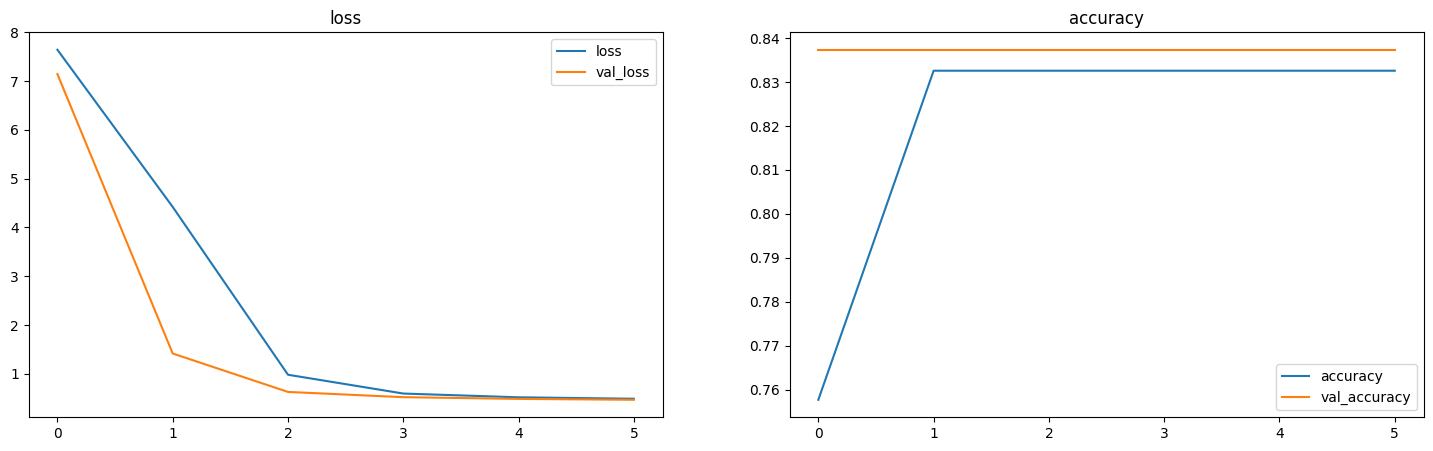

In [35]:
babysit(history.history)

In [56]:
y_pred=model.predict([X_train_p,rev_teacher_enc[0:elements].argmax(axis=1)])


In [58]:
y_pred.shape

(500, 1, 2513)

In [49]:
y_train_encoded.argmax(axis=1)

array([3, 4, 4, 3, 4, 4, 0, 0, 4, 0, 3, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 1,
       2, 4, 1, 4, 4, 0, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4,
       1, 4, 0, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 3, 0, 3, 4, 4,
       0, 3, 0, 4, 0, 3, 0, 0, 4, 2, 0, 0, 2, 4, 4, 0, 3, 0, 4, 4, 4, 0,
       3, 1, 2, 2, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 0, 4, 2, 4, 1, 0,
       4, 3, 4, 2, 4, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 0, 2, 0, 1, 4, 1,
       4, 4, 4, 0, 4, 0, 2, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 3, 4, 4, 4, 2,
       0, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 2, 4, 3, 3, 3, 4, 3, 4, 3, 0, 4,
       4, 4, 2, 4, 3, 4, 3, 4, 3, 3, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 2, 3, 0, 0, 4, 2, 0, 4, 3, 0, 3, 4, 0, 3, 4, 4, 4, 2, 4, 0, 4,
       4, 2, 2, 4, 4, 4, 0, 3, 4, 4, 0, 4, 3, 4, 4, 0, 2, 4, 4, 3, 0, 4,
       3, 4, 1, 0, 4, 4, 4, 4, 4, 4, 3, 1, 4, 2, 2, 4, 4, 4, 4, 2, 1, 0,
       1, 0, 2, 4, 3, 3, 0, 4, 0, 4, 4, 2, 3, 4, 4, 3, 3, 4, 4, 3, 3, 0,
       3, 4, 0, 2, 4, 0, 0, 3, 0, 4, 4, 4, 2, 4, 4,

In [59]:
matrix = confusion_matrix(y_train_encoded.argmax, y_pred.argmax(axis=1))

TypeError: Expected sequence or array-like, got <class 'builtin_function_or_method'>

In [37]:
maxx=0
minn=10
for i in range(80):
    for j in range(1000):
        if max(a[i][1])>maxx:
            maxx=max(a[i][j])
        if min(a[i][1])<minn:
            minn=min(a[i][j])
        
maxx,minn

(0.6744113, 0.45448357)

In [38]:
X_train_p.shape,rev_teacher_enc[0:elements].shape

((500,), (500, 5))

In [39]:
sum(sum(sum(a>0.8)))

0

In [73]:
sum(y_train==)

array([0])

In [65]:
len(y_train)

5000